In [250]:
import time

from dataclasses import dataclass

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset

from torchvision import transforms

import matplotlib.pyplot as plt

from parse import parse

# CNN Model Architecture

In [251]:
class MyModel(nn.Module):
    def __init__(self):
        super().__init__()

        # convolution layers
        self._body = nn.Sequential(
            
            # Size = 32,32

            nn.Conv2d(in_channels = 1, out_channels = 6, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(6),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 6, out_channels = 12, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(12),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),

            # Size = 16, 16

            nn.Conv2d(in_channels = 12, out_channels = 24, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(24),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 24, out_channels = 48, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),

            # Size = 8, 8

            nn.Conv2d(in_channels = 48, out_channels = 96, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 96, out_channels = 144, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(144),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),

            # Size = 4, 4

            nn.Conv2d(in_channels = 144, out_channels = 216, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(216),
            nn.ReLU(inplace = True),

            nn.Conv2d(in_channels = 216, out_channels = 324, kernel_size = 3, bias = False, padding = 1),
            nn.BatchNorm2d(324),
            nn.ReLU(inplace = True),

            nn.MaxPool2d(kernel_size = 2),

            # Out = 2, 2
        )

        # Fully connected layers
        self._head = nn.Sequential(
            nn.Linear(in_features=324 * 2 * 2, out_features=432), 
            nn.ReLU(inplace=True),

            nn.Linear(in_features=432, out_features=144), 
            nn.ReLU(inplace=True),

            nn.Linear(in_features=144, out_features=72),
            nn.ReLU(inplace=True),

            nn.Linear(in_features=72, out_features=10)

        )
        
    def forward(self, data):
        data = self._body(data)
        data = data.view(data.shape[0], -1)
        data = self._head(data)

        return data

## Display Network Architecture

In [252]:
my_model = MyModel()
print(my_model)

MyModel(
  (_body): Sequential(
    (0): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(12, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (8): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(24, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (11): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

# Custom Dataset Class

In [253]:
class DigitsDataset(Dataset):
    def __init__(self, predict = 'train', percent = 1.0, transform = None):

        # initialize the data dictionary
        self.data_dict = {'image': [], 'label': []}

        if predict.lower() == 'train':
            
            images, labels = parse('digitdata/trainingimages', 'digitdata/traininglabels', False)

            # Take a random sample of the training data proportional to percent argument (percent = 1.0 means using all data)
            ammount = int(percent * images.shape[0])
            available_indices = np.random.choice(images.shape[0], ammount, replace = False)
            available_labels = labels[available_indices]
            available_images = images[available_indices]   

            self.data_dict['label'] = torch.tensor(available_labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(available_images, axis=1)).float()
            

        elif predict.lower() == 'val':
            images, labels = parse('digitdata/validationimages', 'digitdata/validationlabels', False)
            self.data_dict['label'] = torch.tensor(labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(images, axis=1)).float()

        elif predict.lower() == 'test':
            images, labels = parse('digitdata/testimages', 'digitdata/testlabels', False)
            self.data_dict['label'] = torch.tensor(labels).long()
            self.data_dict['image'] = torch.tensor(np.expand_dims(images, axis=1)).float()
            
        self.classes = np.array(["Not Face", "Face"])

        self.transform = transform
        self.predict = predict


    def __len__(self):

        return len(self.data_dict['image'])


    def __getitem__(self, idx):

        image = self.data_dict['image'][idx]

        if self.transform:
            image = self.transform(image)

        target = self.data_dict['label'][idx]

        return image, target


## Get DataLoaders for Training and Validation

In [266]:
def get_data(batch_size, val = True, percent = 1.0):
        
    transform = transforms.Compose([transforms.Resize((32,32))])

    train_dataset =  DigitsDataset(predict = 'train', percent = percent, transform = transform)

    if val:
        test_dataset =  DigitsDataset(predict = 'val', transform = transform)
    else:
        test_dataset =  DigitsDataset(predict = 'test', transform = transform)

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
        
    return train_loader, test_loader

## Training Configuration

In [267]:
@dataclass
class TrainingConfiguration:
    batch_size: int = 32 # amount of data to pass through the network at each forward-backward iteration
    epochs: int = 6 # number of times the whole dataset will be passed through the network
    learning_rate: float = 0.001 # determines the speed of network's weights update
    val: bool = True # use validation or test data for validation (True means validation data will be used)
    percent: float = 1.0 # How much of the training data to use for training
    device: str = 'cuda' # Set defualt device

# Training

In [268]:
def train(train_config, model, optimizer, train_loader):
    
    model.train()
    
    # get accuracy
    batch_acc = np.array([])
        
    for data, target in train_loader:
        
        target_index = target.clone()
        data = data.to(train_config.device)
        target = target.to(train_config.device)

        # reset parameters gradient to zero
        optimizer.zero_grad(set_to_none=True)
        
        # forward pass
        output = model(data)
        
        # calculate loss function loss
        loss = F.cross_entropy(output, target)
        
        # back propagation
        loss.backward()
        optimizer.step()
        
        # Get correct predictions from score and target label
        prob = F.softmax(output, dim = 1)
        pred = torch.max(prob.data, dim = 1)[1]  
        correct = torch.sum(pred.cpu()== target_index)
            
        # Get accuracy
        acc = float(correct / len(data))
        
        batch_acc = np.append(batch_acc, [acc])

    epoch_acc = batch_acc.mean()
    return epoch_acc

# Validation

In [328]:
def validate(train_config, model, test_loader):
    model.eval()
    correct = 0

    with torch.no_grad():

        for data, target in test_loader:
            indx_target = target.clone()
            data = data.to(train_config.device)
            target = target.to(train_config.device)
            
            output = model(data)
            
            # Get correct predictions from score and target label
            prob = F.softmax(output, dim=1)
            pred = torch.max(prob.data, dim = 1)[1] 
            correct += torch.sum(pred.cpu() == indx_target)  
        
        accuracy = float(correct / len(test_loader.dataset))
        
    return accuracy

# Main

In [270]:
def main(training_configuration=TrainingConfiguration()):

        torch.manual_seed(42)

        # training_configuration
        batch_size = training_configuration.batch_size
        epochs = training_configuration.epochs
        val = training_configuration.val
        percent = training_configuration.percent
        lr = training_configuration.learning_rate
    
        if torch.cuda.is_available():
            device = "cuda"
            torch.backends.cudnn_benchmark_enabled = True
            torch.backends.cudnn.deterministic = True
        else:
            device = "cpu"

        training_configuration = TrainingConfiguration(device=device)

        # data loader
        train_loader, test_loader = get_data(batch_size=batch_size, val=val, percent = percent)

        # initiate model
        model = MyModel()
        model.to(training_configuration.device)

        optimizer = optim.SGD(model.parameters(), lr=lr, momentum = 0.9)
        
        t_begin = time.time()
        for _ in range(epochs):
            train_acc = train(training_configuration, model, optimizer, train_loader)
        t_end = time.time() - t_begin

        test_acc = validate(training_configuration, model, test_loader)
        
        return model, train_acc, test_acc, time.time() - t_end

## Train with Increasing Ammounts of Data

In [284]:
model, train_acc, test_acc, t = main(training_configuration=TrainingConfiguration(percent = 1.0, val = False, epochs = 6))
print(train_acc)
print(test_acc)

0.9958200636942676
0.9599999785423279


In [ ]:
mean_acc = np.zeros((10, 2), dtype= np.float64)
std = np.zeros((10, 2), dtype= np.float64)
time_func = np.zeros((10, 1), dtype = np.float64)
models = []
iterations = 12

for i in range(1, 11):
    accuracy = np.zeros((iterations, 2), dtype= np.float64)
    avg_time = np.zeros((iterations, 1), dtype= np.float64)

    for iteration in range(0, iterations):
        model, train_acc, test_acc, t = main(TrainingConfiguration(percent = 0.1*i, val = False, epochs=8))
        accuracy[iteration] = train_acc, test_acc
        avg_time[iteration] = t
        
        if i == 10:
            models.append(model)

    mean_acc[i-1] = np.mean(accuracy, axis = 0)
    std[i-1] = np.std(accuracy, axis = 0)
    time_func[i-1] = np.mean(avg_time)

model = models[np.argmax(accuracy[:,1])]


In [329]:
print(f"Average results with all training data over {iterations} runs")
print("Accuracy: Train = {:.4f}, Test = {:.4f}".format(mean_acc[-1,0], mean_acc[-1,1]))
print("StD: Train = {:.6f}, Test = {:.6f}".format(std[-1,0], std[-1,1]))
print("Runtime = {:.3f} seconds".format(time_func[-1][0]))

Average results with all training data over 12 runs
Accuracy: Train = 0.9997, Test = 0.9658
StD: Train = 0.000248, Test = 0.003105
Runtime = 8.870 seconds


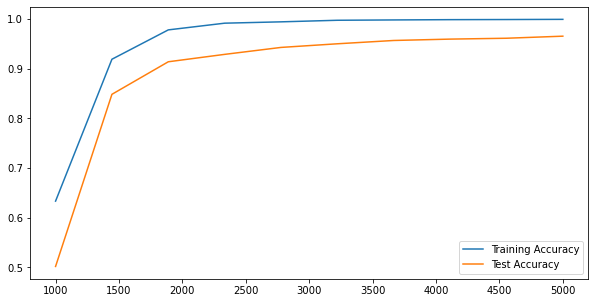

In [290]:
plt.figure(figsize = (10, 5))
x = np.linspace(1000, 5000, 10)
plt.plot(x, mean_acc[:,0], label = "Training Accuracy")
plt.plot(x, mean_acc[:,1], label = "Test Accuracy")
plt.legend()

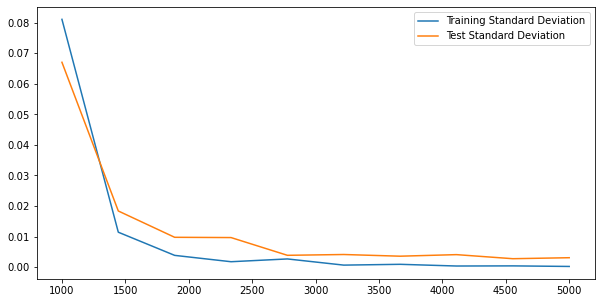

In [293]:
plt.figure(figsize = (10, 5))
x = np.linspace(1000, 5000, 10)
plt.plot(x, std[:,0], label = "Training Standard Deviation")
plt.plot(x, std[:,1], label = "Test Standard Deviation")
plt.legend()

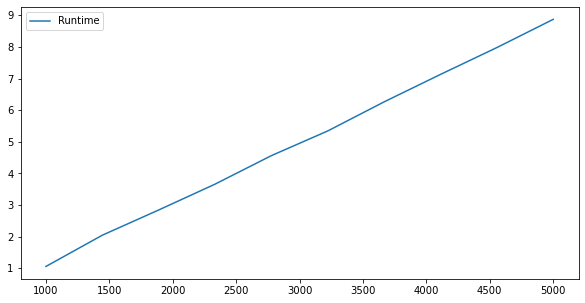

In [294]:
plt.figure(figsize = (10, 5))
x = np.linspace(1000, 5000, 10)
plt.plot(x, time_func, label = "Runtime")
plt.legend()

## Model Prediction

In [309]:
def prediction(model, train_config, inp):
    
    model.to(train_config.device)
    data = inp.to(train_config.device)

    model.eval()
    out = model(data)

    probs = F.softmax(out,1)
    confs = torch.max(probs.data, 1)[0]
    pred_labels = torch.max(probs.data, 1)[1]
    
    return pred_labels.cpu(), confs.cpu()

## Perform Inference on Sample Images

Predicted: 9 (0.99)| Truth: 9


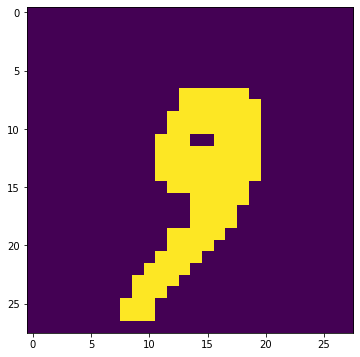

Predicted: 0 (0.99)| Truth: 0


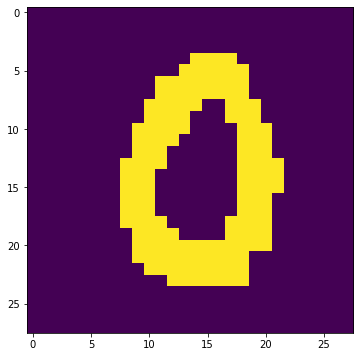

Predicted: 2 (0.99)| Truth: 2


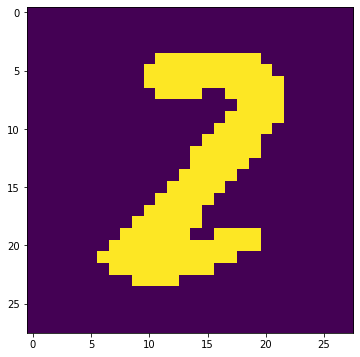

Predicted: 5 (0.97)| Truth: 5


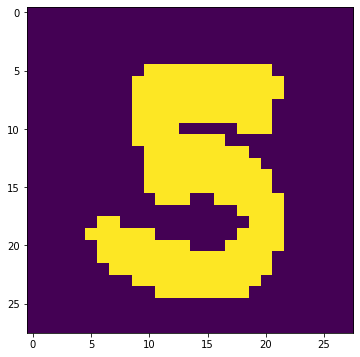

Predicted: 1 (0.99)| Truth: 1


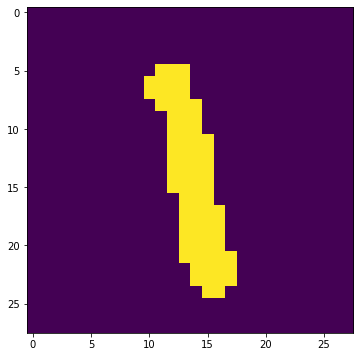

In [310]:
batch_size = 5
train_config = TrainingConfiguration()

if torch.cuda.is_available():
    train_config.device = "cuda"
else:
    train_config.device = "cpu"

# load testdata with image transformation
transform = transforms.Compose([transforms.Resize((32,32))])

test_loader = torch.utils.data.DataLoader( DigitsDataset(predict = 'test', transform = transform), batch_size=5, shuffle = False)

display_loader = torch.utils.data.DataLoader( DigitsDataset(predict = 'test', transform = None), batch_size=5, shuffle = False)

for data, label in test_loader:
    # pass the loaded model
    preds, probs = prediction(model, train_config, data)
    break

for data, label in display_loader:
    for index, img in enumerate(data):
        print(f"Predicted: {preds[index]} ({float(int(probs[index]*100))/100})| Truth: {label[index]}".format())
        plt.imshow(img.cpu()[0]) 
        plt.show()
    break